In [18]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [19]:
ts_p = 120
ts_c = 40

end_d = 6
end_s = end_d *24 *60 * 60
itend_p = end_s/ts_p
itend_c = end_s/ts_c


print('rn_rdt parent (and rn_rdtmin/max): ', ts_p)
print('rn_rdt child (and rn_rdtmin/max): ', ts_c)
print('nn_itend parent (and nn_stock): ', itend_p)
print('nn_itend child (and nn_stock): ', itend_c)

rn_rdt parent (and rn_rdtmin/max):  120
rn_rdt child (and rn_rdtmin/max):  40
nn_itend parent (and nn_stock):  4320.0
nn_itend child (and nn_stock):  12960.0


# Summary
Finding the hour when salinities start to go over the max salinity in the initial profile. This is specifically for dep_ind=8 (74 m).

|child           |time [hrs]| salinity|time [hrs]| salinity|
|----------------|--|-----------------|--|-----------------|
|ideal_double_flt|45|35.08|479|36.6084|
|ideal_double (ts)|44|35.0735|-|-|
|**ideal_base_flt**   |86|35.0699|479|35.6176|
|**ideal_base (ts)**  |85|35.0665|-|-|
|**ideal_base_nambfr**|124|35.0636|-|-|
|**ideal_base_e3zps** |-|-|-|-|
|**ideal_double_e3zps** |116|35.065|359|35.6244|
|ideal_half      |-|-|-|-|
|real_base       |-|-|-|-|
|real_half       |-|-|-|-|



|parent           |time [hrs]| salinity|time [hrs]| salinity|
|----------------|--|-----------------|--|-----------------|
|ideal_double_flt|43|35.0968|479|36.1203|
|ideal_double (ts)|42|35.0874|-|-|
|**ideal_base_flt**   |293|35.0642|479|35.4966|
|**ideal_base (ts)**  |283|35.0641|-|-|
|**ideal_base_nambfr**|171|35.0631|-|-|
|**ideal_base_e3zps** |-|-|-|-|
|**ideal_double_e3zps** |249|35.0636|359|35.2611|
|ideal_half      |-|-|-|-|
|real_base       |-|-|-|-|
|real_half       |-|-|-|-|

|Key|Parent: rn_rdt & rn_rdtmin/max| Child: rn_rdt & rn_rdtmin/max|Parent: nn_itend & nn_stock| Child: nn_itend & nn_stock| rn_bt_cmax |barotropic ts [s] p&c|
|-|--------|----------|-----|-----|---|-----------|
|A|240 (4m)|80 (1m20s)|7200 |21600|0.5|           |
|B|180 (3m)|60 (1m)   |9600 |28800|0.5|           |
|C|240 (4m)|80 (1m20s)|7200 |21600|0.3|3.75 & 1.25|
|D|        |          |     |     |0.2|2.50 & 0.83|
|E|        |          |     |     |0.1|1.25 & 0.41|
|F|120 (2m)|40        |14400|43200|0.5|6.00 & 2.00|
|G|120 (2m)|40        |10800|32400|0.5|           |
|H|        |          |     |     |   |           |
|I|        |          |     |     |   |           |
|J|        |          |4320 |12960|   |           |
|K|        |          |     |     |   |           |



|Key|ideal_base|ideal_half|ideal_double|real_base|real_half|real_double|changes|
|-|---------|---------|---------|---------|---------|----|-|
|A|11728    |21600    |1026     |959      |9539     |671 ||
|B|28800    |12847    |         |1962     |16799    |968 ||
|C|         |         |         |959      |         |    ||
|D|         |         |         |959      |         |    ||
|E|         |         |         |959      |         |    |filtered|
|F|39175    |**43200**|         |**43200**|**43200**|1717|timesplitting|
|G|23433    |         |**22746**|         |         |    |timesplitting|
|G|**28527**|         |7056     |         |         |    |timesplitting|
|H (_nambfr)|**32400**|         |         |         |         |    |nambfr|
|I (_e3zps) |**32400**|         |**32400**|         |         |    |nambfr + partial steps|
|J (_traldf)|         |error    |         |         |         |    |itend + nambfr + partial steps + namtra_ldf|
|K (_bfrimp)|         |         |         |         |         |    |itend + nambfr + partial steps + bfrimp|

# Most recent double

    !-----------------------------------------------------------------------
    &nambfr        !   bottom friction
    !-----------------------------------------------------------------------
       nn_bfr      =    2       !  type of bottom friction :   = 0 : free slip,  = 1 : linear friction
                                !                              = 2 : nonlinear friction
       rn_bfri1    =    4.e-4   !  bottom drag coefficient (linear case)
       rn_bfri2    =    7.5e-3  !  bottom drag coefficient (non linear case). Minimum coeft if ln_loglayer=T
       rn_bfri2_max =   2.      !  max. bottom drag coefficient (non linear case and ln_loglayer=T)
       rn_bfeb2    =    2.5e-3  !  bottom turbulent kinetic energy background  (m2/s2)
       rn_bfrz0    =    0.07    !  bottom roughness [m] if ln_loglayer=T
       ln_bfr2d    = .false.    !  horizontal variation of the bottom friction coef (read a 2D mask file )
       rn_bfrien   =    400.    !  local multiplying factor of bfr (ln_bfr2d=T)
       rn_tfri1    =    4.e-4   !  top drag coefficient (linear case)
       rn_tfri2    =    2.5e-3  !  top drag coefficient (non linear case). Minimum coeft if ln_loglayer=T
       rn_tfri2_max =   1.e-1   !  max. top drag coefficient (non linear case and ln_loglayer=T)
       rn_tfeb2    =    0.0     !  top turbulent kinetic energy background  (m2/s2)
       rn_tfrz0    =    3.e-3   !  top roughness [m] if ln_loglayer=T
       ln_tfr2d    = .false.    !  horizontal variation of the top friction coef (read a 2D mask file )
       rn_tfrien   =    50.     !  local multiplying factor of tfr (ln_tfr2d=T)

       ln_bfrimp   = .true.     !  implicit bottom friction (requires ln_zdfexp = .false. if true)
       ln_loglayer = .true.    !  logarithmic formulation (non linear case)
## ---------------------------------------------------------------------------------------------------------------------

    !-----------------------------------------------------------------------
    &namdom        !   space and time domain (bathymetry, mesh, timestep)
    !-----------------------------------------------------------------------     
       rn_hmin     =   8.75    !  min depth of the ocean (>0) or min number of ocean level (<0)
       rn_e3zps_min=   2000    !  5.0 partial step thickness is set larger than the minimum of
       rn_e3zps_rat=   1       !  0.25 rn_e3zps_min and rn_e3zps_rat*e3t, with 0<rn_e3zps_rat<1
## ---------------------------------------------------------------------------------------------------------------------

    !-----------------------------------------------------------------------
    &namrun        !   parameters of the run
    !-----------------------------------------------------------------------
       nn_itend    =      4320  ! last  time step
## ---------------------------------------------------------------------------------------------------------------------

    !----------------------------------------------------------------------------------
    &namtra_ldf    !   lateral diffusion scheme for tracers
    !----------------------------------------------------------------------------------
       ln_traldf_hor    =  .true.  !  horizontal (geopotential)   (needs "key_ldfslp" when ln_sco=T)
       ln_traldf_iso    =  .false.   !  iso-neutral                 (needs "key_ldfslp")

    ===>>> : E R R O R
    ===========
          eddy induced velocity on tracers
          the eddy induced velocity on tracers requires isopycnal laplacian diffusion
          laplacian operator
** I switched the iso back on and hor off, and moved on to the next thing.**
## ---------------------------------------------------------------------------------------------------------------------

    ln_bfrimp   = .false.     !  implicit bottom friction (requires ln_zdfexp = .false. if true)
## ---------------------------------------------------------------------------------------------------------------------

In [20]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][0, :, 0, 0]
#for z in range(len(vosaline_ref)):
    #print(str(z) + '-- ' + str(vosaline_ref[z]))
print('MAXIMUM-- ' + str(vosaline_ref.max()))

MAXIMUM-- 35.0629


In [21]:
def get_vars(fname, dirname, dep_ind, time_ind):
    
    if fname == '1_MCKNZ_1h_20170101_201701*':
        maskname = '1_mesh_mask.nc'
    elif fname == 'MCKNZ_1h_20170101_201701*':
        maskname = 'mesh_mask.nc'
    
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU:
        deptht = dsT.variables['deptht'][:]
        vosaline0 = dsT.variables['vosaline'][time_ind, dep_ind, y, x]
        
    with nc.Dataset(os.path.join(dirname, maskname), 'r') as dsM:
        tmask = dsM.variables['tmask'][0, dep_ind, y, x]
        e3t = dsM.variables['e3t_0'][0, dep_ind, y, x]
        
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vosaline, deptht, tmask, e3t

In [29]:
def get_salt(fname, dirname, maskname, time_ind, dep_ind, y, x):
    #y,x = slice(1,-1,None), slice(1,-1,None)
    #(272, 242) vs (274, 244)
    y, x = y+1, x+1
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    
    with scDataset(filesT) as dsT:
        vosaline = dsT.variables['vosaline'][time_ind, dep_ind, y, x]
        
    with nc.Dataset(os.path.join(dirname, maskname), 'r') as dsM:
        e3t = dsM.variables['e3t_0'][0, dep_ind, y, x]
        
    return vosaline, e3t

In [22]:
def plot_salt(fname, dirname, case, time_ind, vosaline_ref, flag):
    fig, axes = plt.subplots(3, 4, figsize=(20, 14), sharex=True, sharey=True)

    dep_inds = np.arange(5, 17)
    coords = np.full([len(dep_inds), 3], np.nan, dtype=int)
    salmax_salt_all = np.full([len(dep_inds)], np.nan)

    for ax, dep_ind, n in zip(axes.flatten(), dep_inds, np.arange(len(dep_inds))):

        vosaline, deptht, tmask, e3t = get_vars(fname, dirname+case, dep_ind, time_ind)
        
        if flag == 'anomaly':
            vmin, vmax = -7, 7
            plot_array = vosaline - vosaline_ref[dep_ind]
            cmap = cmo.cm.delta
        else:    
            vmin, vmax = 34.5, 35.063
            plot_array = vosaline
            cmap = cm.Spectral_r

        salmax_y = np.where(plot_array == plot_array.max())[-2][0]
        salmax_x = np.where(plot_array == plot_array.max())[-1][0]
        salmax_e3t = e3t[salmax_y, salmax_x]
        salmax_tmask = tmask[salmax_y, salmax_x]
        salmax_salt = plot_array[salmax_y, salmax_x]
        e3t_tmask = salmax_e3t * salmax_tmask
        
        coords[n, 0] = dep_ind
        coords[n, 1] = salmax_y
        coords[n, 2] = salmax_x
        salmax_salt_all[n] = salmax_salt
        
        cmap.set_bad('silver')
        xs = np.arange(vosaline.shape[-1])
        ys = np.arange(vosaline.shape[-2])
        
        p = ax.pcolormesh(xs, ys, plot_array, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.scatter(salmax_x, salmax_y, s=200, facecolors='none', edgecolors='w', lw=2)
        ax.annotate('x,y = '+str(salmax_x)+', '+str(salmax_y), xy=(130, 30), fontsize=16)
        ax.annotate('salt = '+str(np.round(salmax_salt, 3)), xy=(130, 20), fontsize=16)
        ax.annotate('thick = '+str(np.round(e3t_tmask, 3)), xy=(130, 10), fontsize=16)
        ax.set_aspect(aspect='equal')
        ax.set_xlim([50, 170])
        ax.set_ylim([10, 180])
        ax.set_ylabel(str(deptht[dep_ind]), fontsize=16)

        axins = inset_axes(ax,
                        width="5%",  # width = 10% of parent_bbox width
                        height="40%",  # height : 50%
                        loc=3)
        axins.xaxis.set_ticks_position("bottom")
        cbar = fig.colorbar(p, cax=axins, orientation='vertical')
    fig.tight_layout(h_pad=0.1, w_pad=0.2)
    return fig, coords, salmax_salt_all

In [23]:
def wrap_wall(fname, dirname, case, time_ind, maskname, ind_off):
    y,x = slice(1,-1,None), slice(1,-1,None)
    with nc.Dataset(os.path.join(dirname+case, maskname), 'r') as dsM:
        tmask = dsM.variables['tmask'][0, :, y, x]
    
    zs = np.arange(5, 21)
    xs = np.arange(40, 180)
    ys = np.full([len(zs), len(xs)], np.nan)
    
    salt_wall = np.full([len(zs), len(xs)], np.nan)
    e3t_wall = np.full([len(zs), len(xs)], np.nan)
    print(salt_wall.max())

    for n in range(len(zs)):
        k = zs[n]
        print(k)

        for m in range(len(xs)):
            i = xs[m]

            j = np.where(tmask[k, :, i] == 1)[0][ind_off]
            ys[n, m] = j
            
            salt_wall[n, m], e3t_wall[n, m] = get_salt(fname, dirname+case, maskname, time_ind, k, j, i)
    
    print(salt_wall.min(), salt_wall.max())
    return xs, ys, zs, salt_wall, e3t_wall, tmask

In [24]:
def plot_tmask_wall(xs, ys, zs, tmask, coords, salmax_salt_all):
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 14), sharey=True)
    for ax, k, n in zip(axes.flatten(), zs, np.arange(len(zs))):
        ax.pcolormesh(tmask[k, :, :], cmap=cm.Greys_r)
        ax.plot(xs, ys[n, :], c='r', lw=3)
        ind = np.where(coords[:, 0]==k)[0][0]
        salmax_x = coords[ind][-1]
        salmax_y = coords[ind][-2]
        salmax_salt = salmax_salt_all[ind]
        ax.scatter(salmax_x, salmax_y, s=100, facecolors='none', edgecolors='b', lw=2)
        
        ax.annotate('x,y = '+str(salmax_x)+', '+str(salmax_y), xy=(130, 250), fontsize=16, color='k')
        ax.annotate('salt = '+str(np.round(salmax_salt, 3)), xy=(130, 230), fontsize=16, color='k')
        
        ax.set_title(str(k))
        ax.set_xlim([0, tmask.shape[-1]])
        ax.set_ylim([0, tmask.shape[-2]])
        
    fig.tight_layout(h_pad=0.1, w_pad=0.2)
    return fig

In [25]:
def plot_wrap_wall(xs, zs, salt_wall, e3t_wall, vosaline_ref, vmin, vmax):
    
    vosaline_ref_extract = vosaline_ref[zs[0]:zs[-1]+1]
    vosaline_anomaly = np.full_like(salt_wall, np.nan)

    for i in range(len(vosaline_ref_extract)):
        vosaline_anomaly[i, :] = salt_wall[i, :] - vosaline_ref_extract[i]
    
    zs_plot = np.append(zs, (zs[-1]+1))
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12))
    for ax, n in zip([ax1, ax2, ax3], np.arange(3)):
        if ax == ax1:
            plot_array = salt_wall
            vmin, vmax = vmin, vmax
            cmap = cm.Spectral_r
            ttl = 'salinity'
        elif ax == ax2:
            plot_array = vosaline_anomaly
            vmin, vmax = -7, 7
            cmap = cmo.cm.balance
            ttl = 'salinity anomaly'
        elif ax == ax3:
            plot_array = e3t_wall
            vmin, vmax = 2, 8
            cmap = cm.terrain
            ttl = 'thickness'
        cmap.set_bad('silver')    
        p = ax.pcolormesh(xs, zs_plot, plot_array, cmap = cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(p, ax=ax, pad=0.02)
        ax.set_ylim([zs_plot[-1], zs_plot[0]])
        ax.set_ylabel(ttl, fontsize=16)
    fig.tight_layout(h_pad=0.5)
    return fig

# Implicit bottom friction

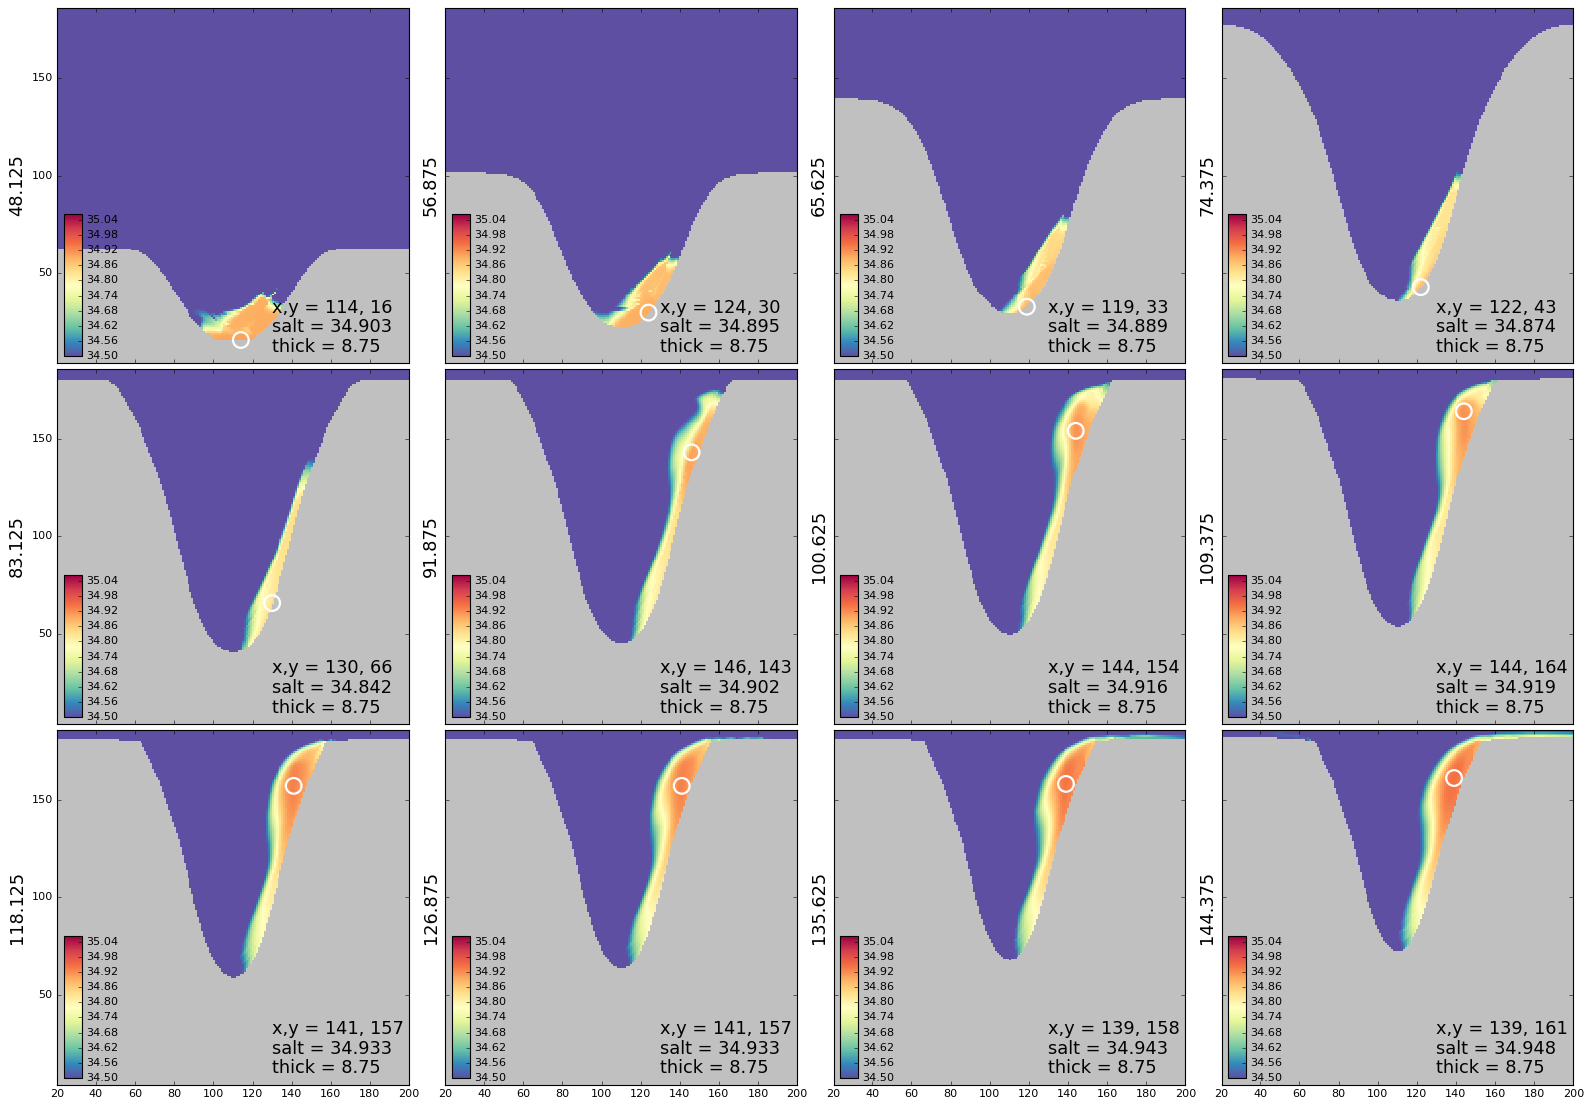

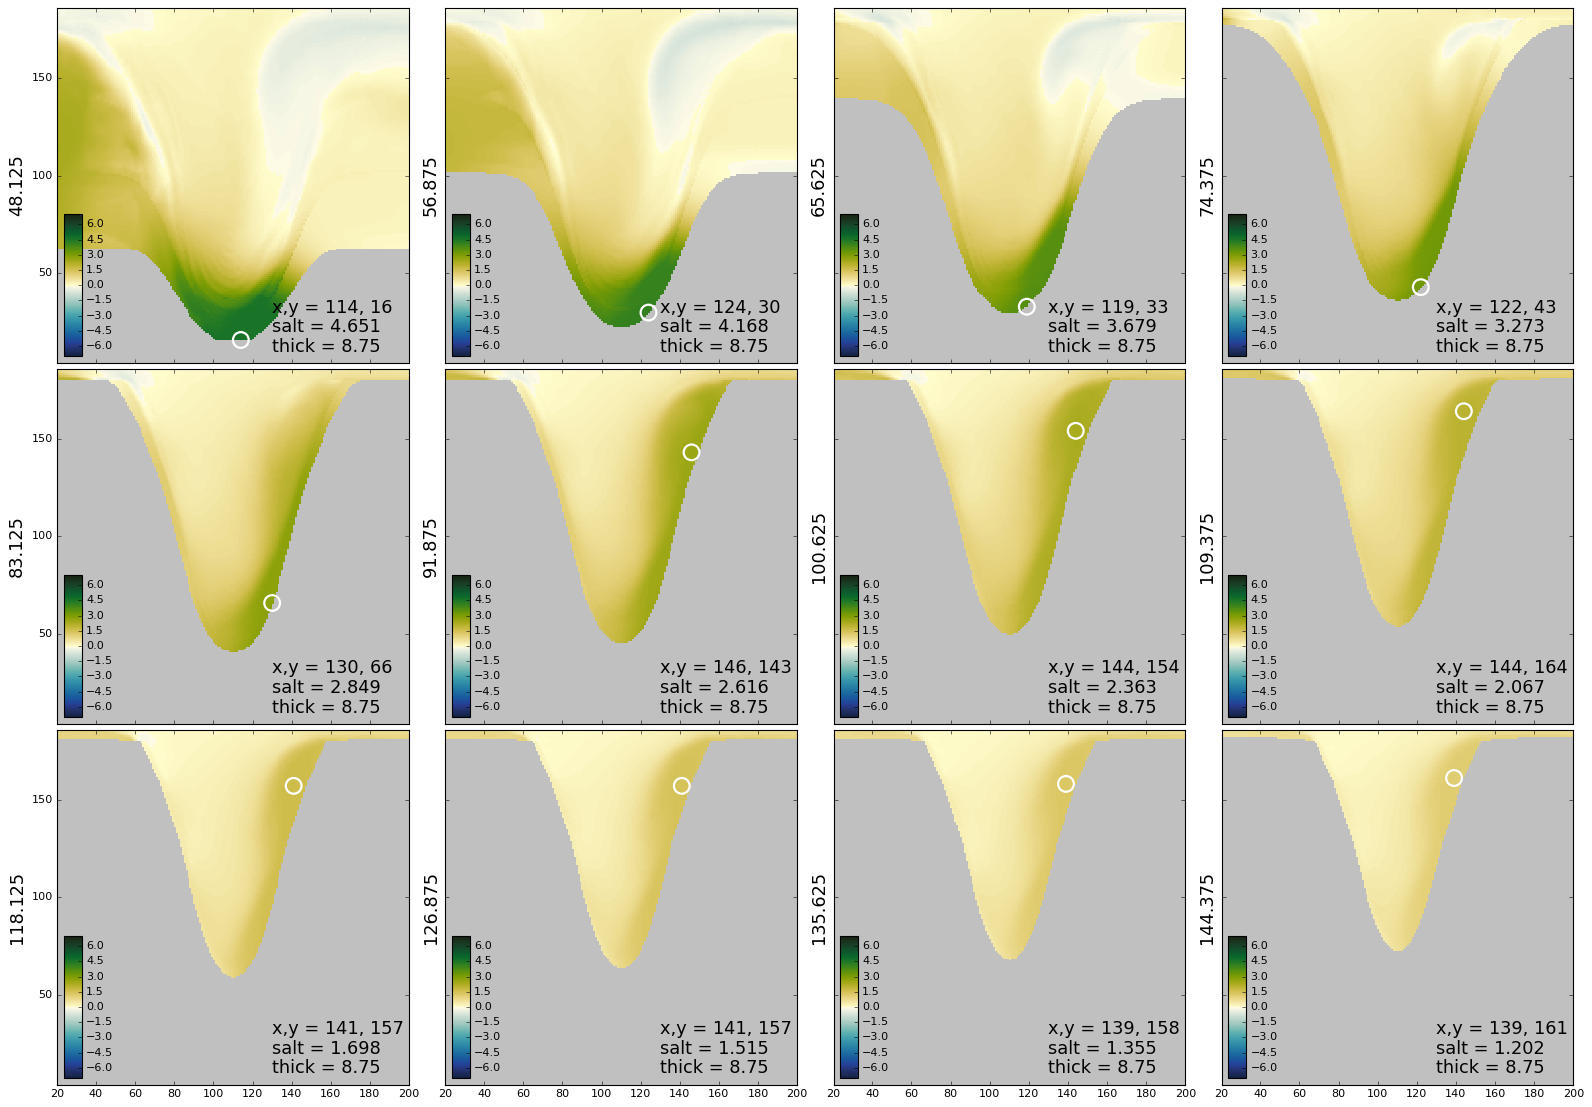

In [28]:
fname = '1_MCKNZ_1h_20170101_201701*'
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/'
case = 'ideal_double_bfrimp'
time_ind=85
maskname = '1_mesh_mask.nc'

fig, coords, salmax_salt_all = plot_salt(fname, dirname, case, time_ind, vosaline_ref, None)
fig, coords, salmax_salt_all = plot_salt(fname, dirname, case, time_ind, vosaline_ref, 'anomaly')

In [30]:
xs, ys, zs, salt_wall, e3t_wall, tmask = wrap_wall(fname, dirname, case, time_ind, maskname, 4)

nan
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
30.4024620056 34.9711685181


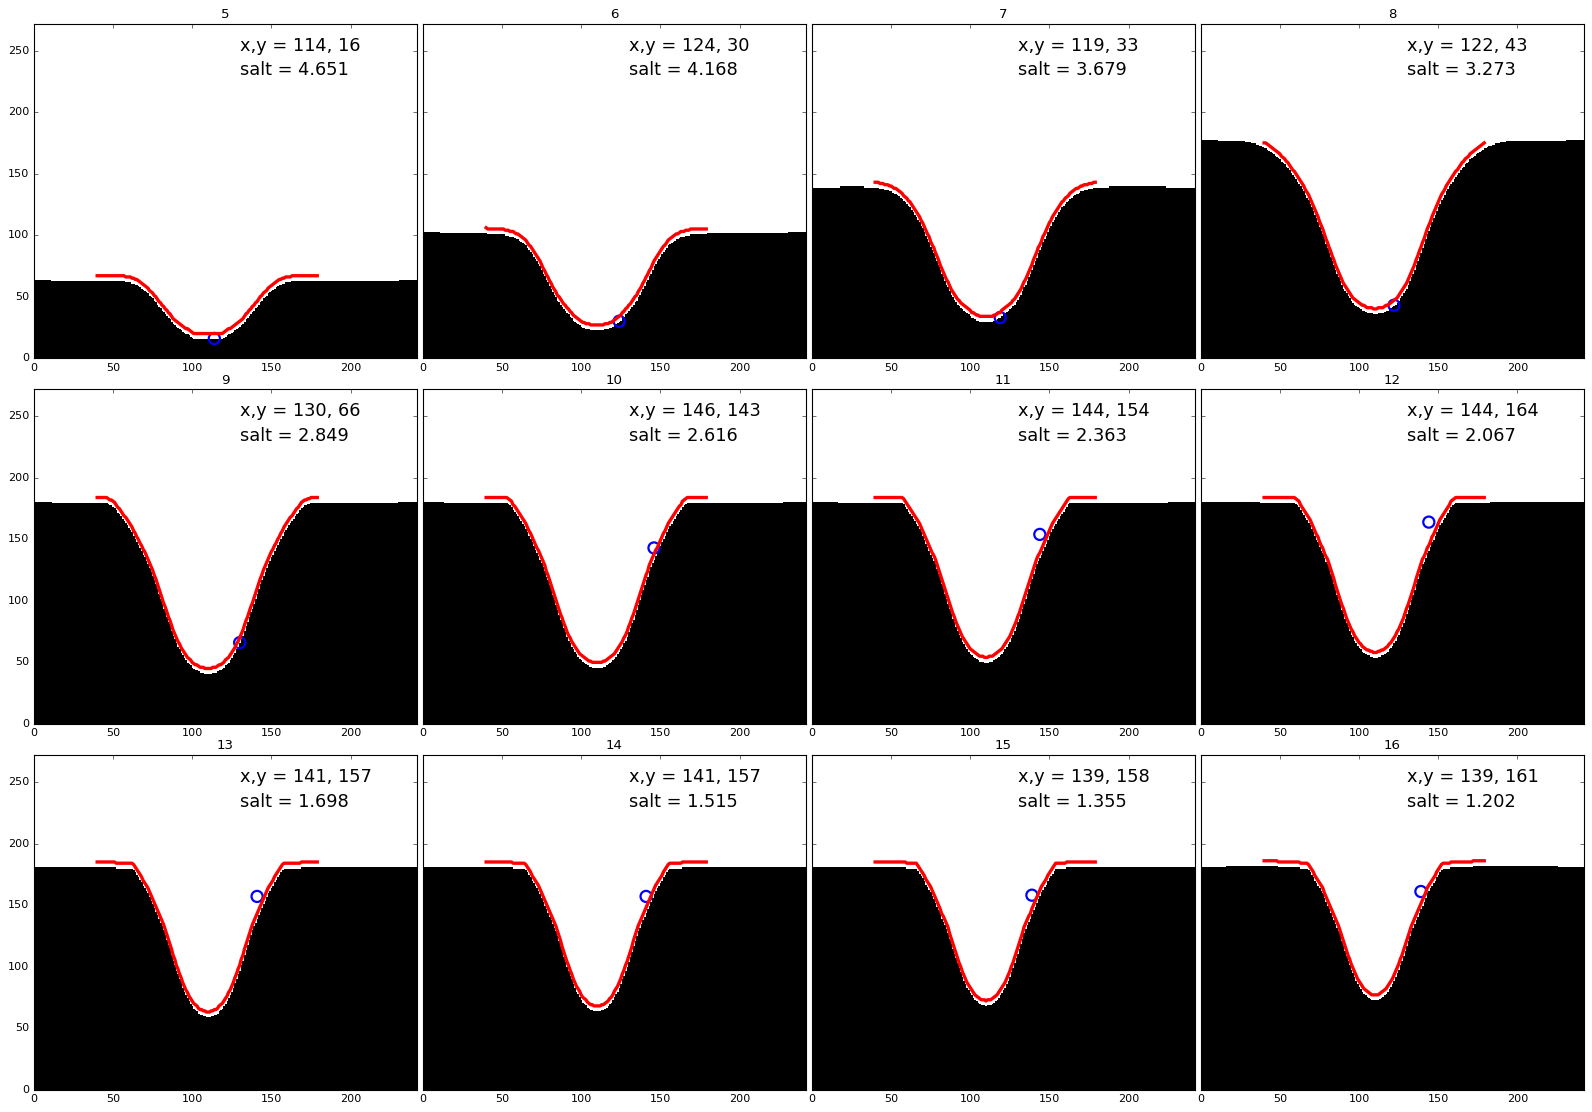

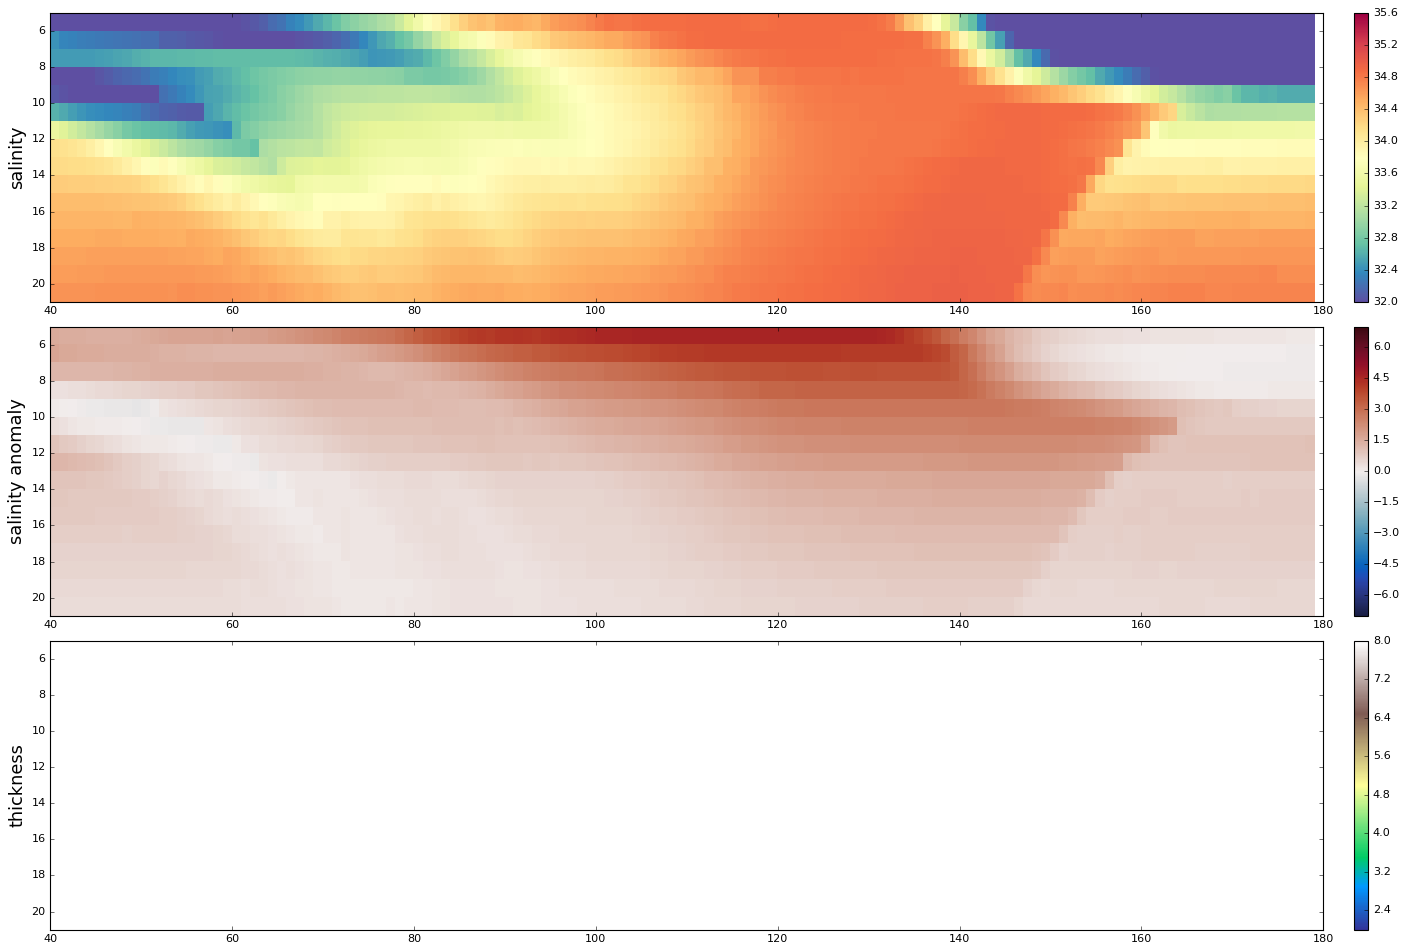

In [32]:
fig = plot_tmask_wall(xs, ys, zs, tmask, coords, salmax_salt_all)
fig = plot_wrap_wall(xs, zs, salt_wall, e3t_wall, vosaline_ref, 32, 35.6)

In [33]:
xs, ys, zs, salt_wall, e3t_wall, tmask = wrap_wall(fname, dirname, case, time_ind, maskname, 1)

nan
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
30.3955211639 34.9706420898


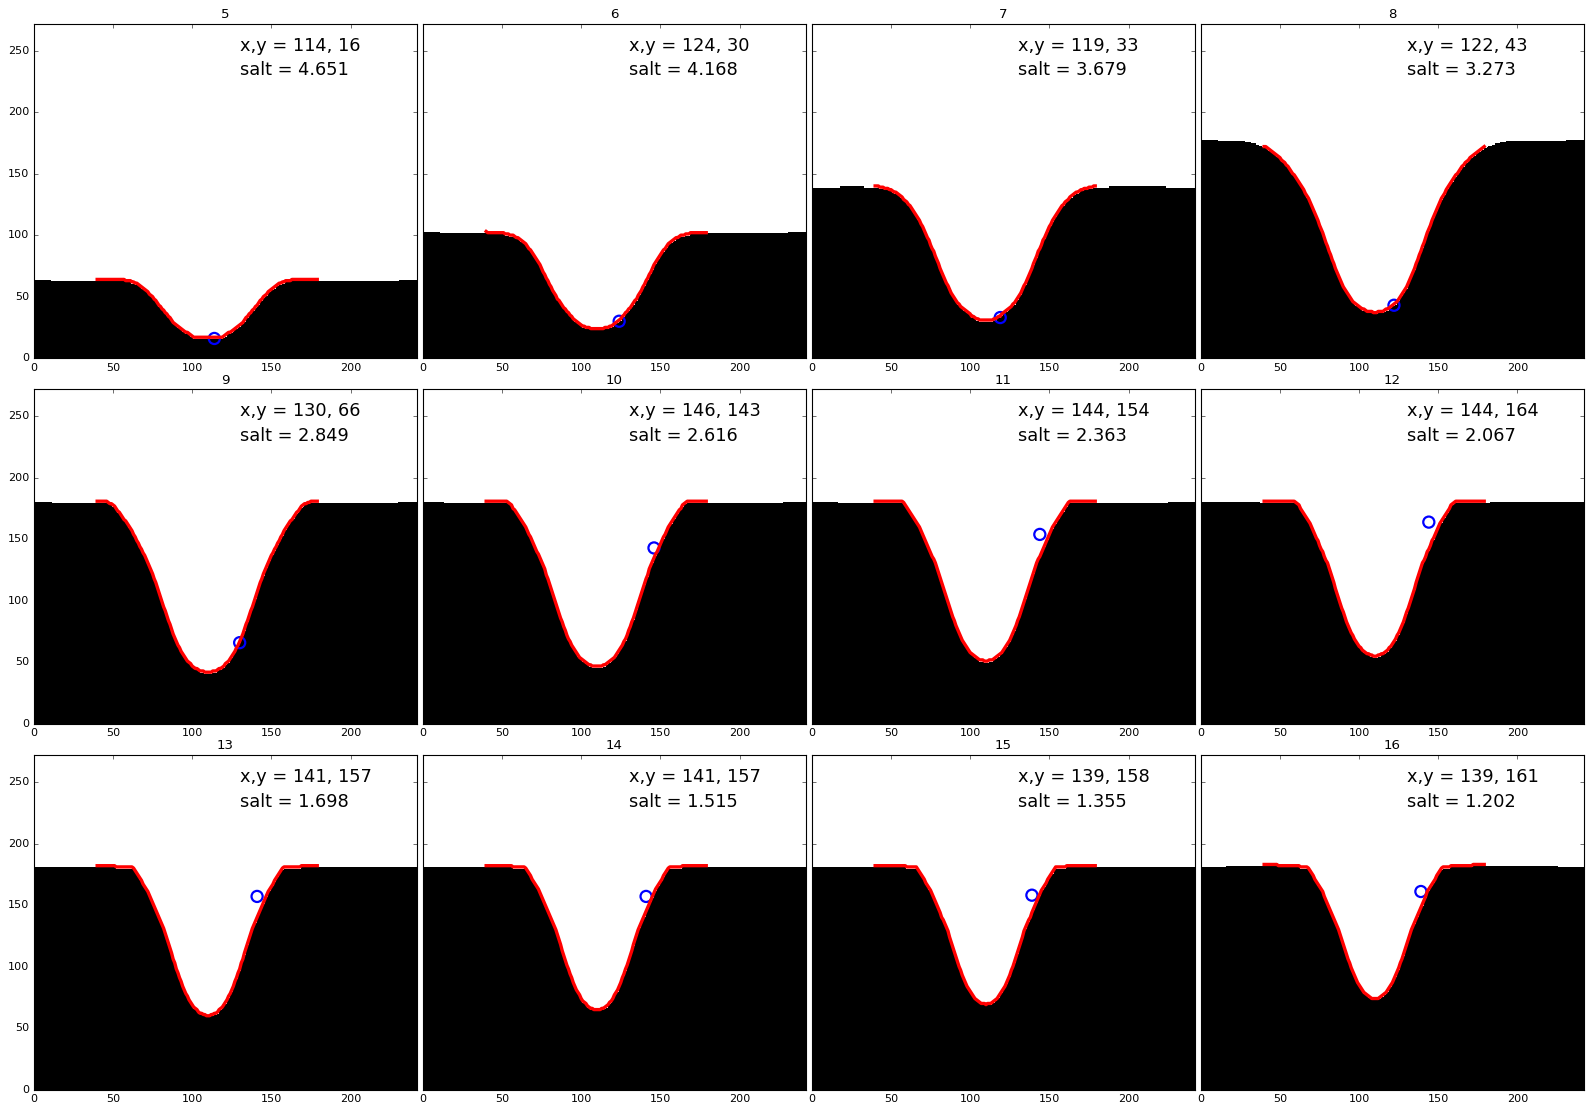

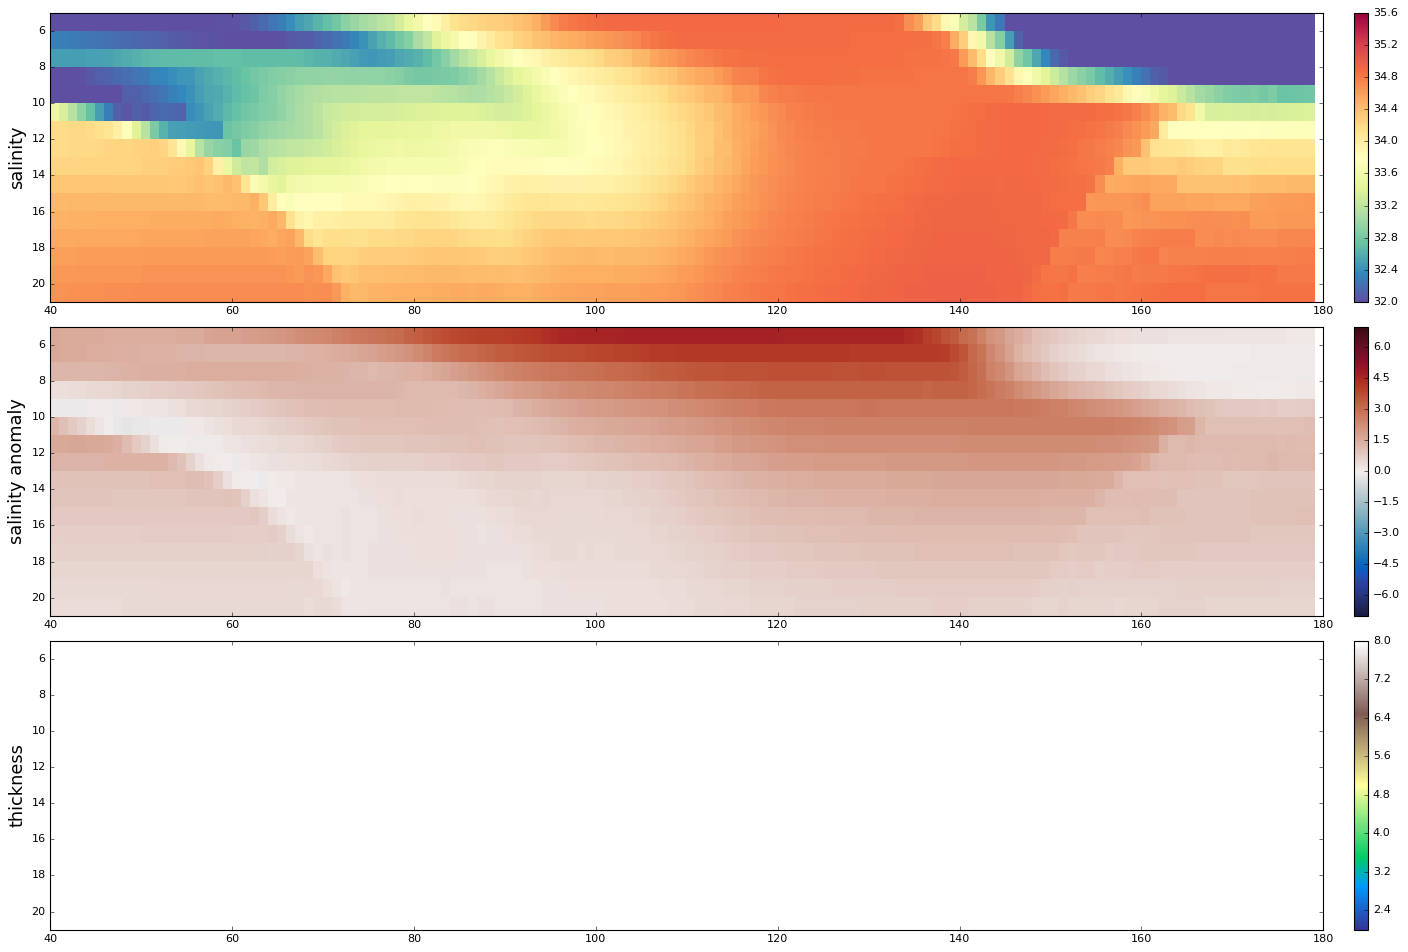

In [34]:
fig = plot_tmask_wall(xs, ys, zs, tmask, coords, salmax_salt_all)
fig = plot_wrap_wall(xs, zs, salt_wall, e3t_wall, vosaline_ref, 32, 35.6)